In [1]:
import polars as pl
import pandas as pd
import numpy as np
import altair as alt
import sklearn

alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Data Analysis

In [2]:
from sklearn import datasets

data = datasets.fetch_20newsgroups(subset='all')

In [3]:
df = pd.DataFrame({
    'text': data.data,
    'target': data.target
})

df['target_name'] = [data.target_names[i] for i in df['target']]

In [4]:
base = alt.Chart(df).mark_bar().encode(
    x=alt.X('target_name:O', title='Target Name', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('count()', title='Frequency'),
    color=alt.Color('target_name:N', title=''),
    tooltip=[
        alt.Tooltip('target_name:O', title='Target Name'),
        alt.Tooltip('target:O', title='Target Number'),
        alt.Tooltip('count()', title='Frequency')
    ],
)

final_chart = (base).properties(
    width=900,
    height=400,
    title='Distribution of 20 Target Names'
)

final_chart

alt.Chart(...)

# MLflow

In [5]:
import mlflow
import os

mlflow_uri = os.getenv('MLFLOW_TRACKING_URI', 'http://mlflow:5000')

In [6]:
mlflow.set_tracking_uri(uri=mlflow_uri)

mlflow.autolog(disable=True)

# PyTorch

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sentence_transformers import SentenceTransformer

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Embedding Model

In [9]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # 384-d
emb_model = SentenceTransformer(model_name, device=device)

## Data Preprocessing PyTorch

In [10]:
texts = df["text"].fillna("").tolist()
embeddings = emb_model.encode(
    texts,
    batch_size=128,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=True,
)

Batches:   0%|          | 0/148 [00:00<?, ?it/s]

In [11]:
import numpy as np
X_emb = torch.from_numpy(embeddings).float()
y_lbl = torch.as_tensor(df["target"].values, dtype=torch.long)
X_emb.shape, y_lbl.shape

(torch.Size([18846, 384]), torch.Size([18846]))

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(
    X_emb, y_lbl, test_size=0.2, random_state=42, stratify=y_lbl
)

In [13]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_dl = DataLoader(
    train_ds, batch_size=256, shuffle=True,
    num_workers=2, pin_memory=torch.cuda.is_available()
)
val_dl = DataLoader(
    val_ds, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=torch.cuda.is_available()
)

In [14]:
import torch.nn as nn

in_dim = X_emb.shape[1]           # 384 для all-MiniLM-L6-v2
num_classes = len(set(df["target"]))

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [15]:
model = NeuralNetwork(in_dim, num_classes).to(device)
model

NeuralNetwork(
  (net): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=256, bias=True)
    (2): SiLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=20, bias=True)
  )
)

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Recreate the model, to initialize new weights

## Training

In [17]:
model = NeuralNetwork(in_dim, num_classes).to(device)

In [18]:
import mlflow
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs = 35

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

exp = mlflow.set_experiment(experiment_name="20 News Group PyTorch")

with mlflow.start_run(experiment_id=exp.experiment_id):
    mlflow.log_param("embedding_model", model_name)
    mlflow.log_param("in_dim", int(in_dim))

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_acc += (logits.argmax(1) == yb).float().sum().item()

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                val_acc += (logits.argmax(1) == yb).float().sum().item()
        
        n_tr, n_va = len(train_ds), len(val_ds)
        train_loss /= n_tr; train_acc /= n_tr
        val_loss /= n_va; val_acc /= n_va

        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }, step = epoch)

        print(f"Epoch {epoch:02d} | train_acc={train_acc:.3f} val_acc={val_acc:.3f}")

Epoch 01 | train_acc=0.599 val_acc=0.764
Epoch 02 | train_acc=0.775 val_acc=0.793
Epoch 03 | train_acc=0.808 val_acc=0.809
Epoch 04 | train_acc=0.829 val_acc=0.825
Epoch 05 | train_acc=0.848 val_acc=0.832
Epoch 06 | train_acc=0.864 val_acc=0.835
Epoch 07 | train_acc=0.876 val_acc=0.842
Epoch 08 | train_acc=0.885 val_acc=0.844
Epoch 09 | train_acc=0.893 val_acc=0.849
Epoch 10 | train_acc=0.906 val_acc=0.851
Epoch 11 | train_acc=0.914 val_acc=0.859
Epoch 12 | train_acc=0.922 val_acc=0.858
Epoch 13 | train_acc=0.930 val_acc=0.858
Epoch 14 | train_acc=0.939 val_acc=0.865
Epoch 15 | train_acc=0.944 val_acc=0.864
Epoch 16 | train_acc=0.949 val_acc=0.866
Epoch 17 | train_acc=0.954 val_acc=0.867
Epoch 18 | train_acc=0.957 val_acc=0.870
Epoch 19 | train_acc=0.963 val_acc=0.866
Epoch 20 | train_acc=0.969 val_acc=0.868
Epoch 21 | train_acc=0.974 val_acc=0.871
Epoch 22 | train_acc=0.974 val_acc=0.872
Epoch 23 | train_acc=0.979 val_acc=0.871
Epoch 24 | train_acc=0.978 val_acc=0.874
Epoch 25 | train

## Inference

In [19]:
sample_texts = df["text"].iloc[:3].tolist()
emb = emb_model.encode(sample_texts, convert_to_numpy=True, normalize_embeddings=True)
with torch.no_grad():
    logits = model(torch.from_numpy(emb).float().to(device))
    preds = logits.softmax(1).argmax(1).cpu().numpy()
[data.target_names[p] for p in preds]

['rec.sport.hockey', 'comp.sys.ibm.pc.hardware', 'talk.politics.mideast']

In [20]:
sample_texts

["From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which h

## MLflow Runs

### MLflow all runs and comparison

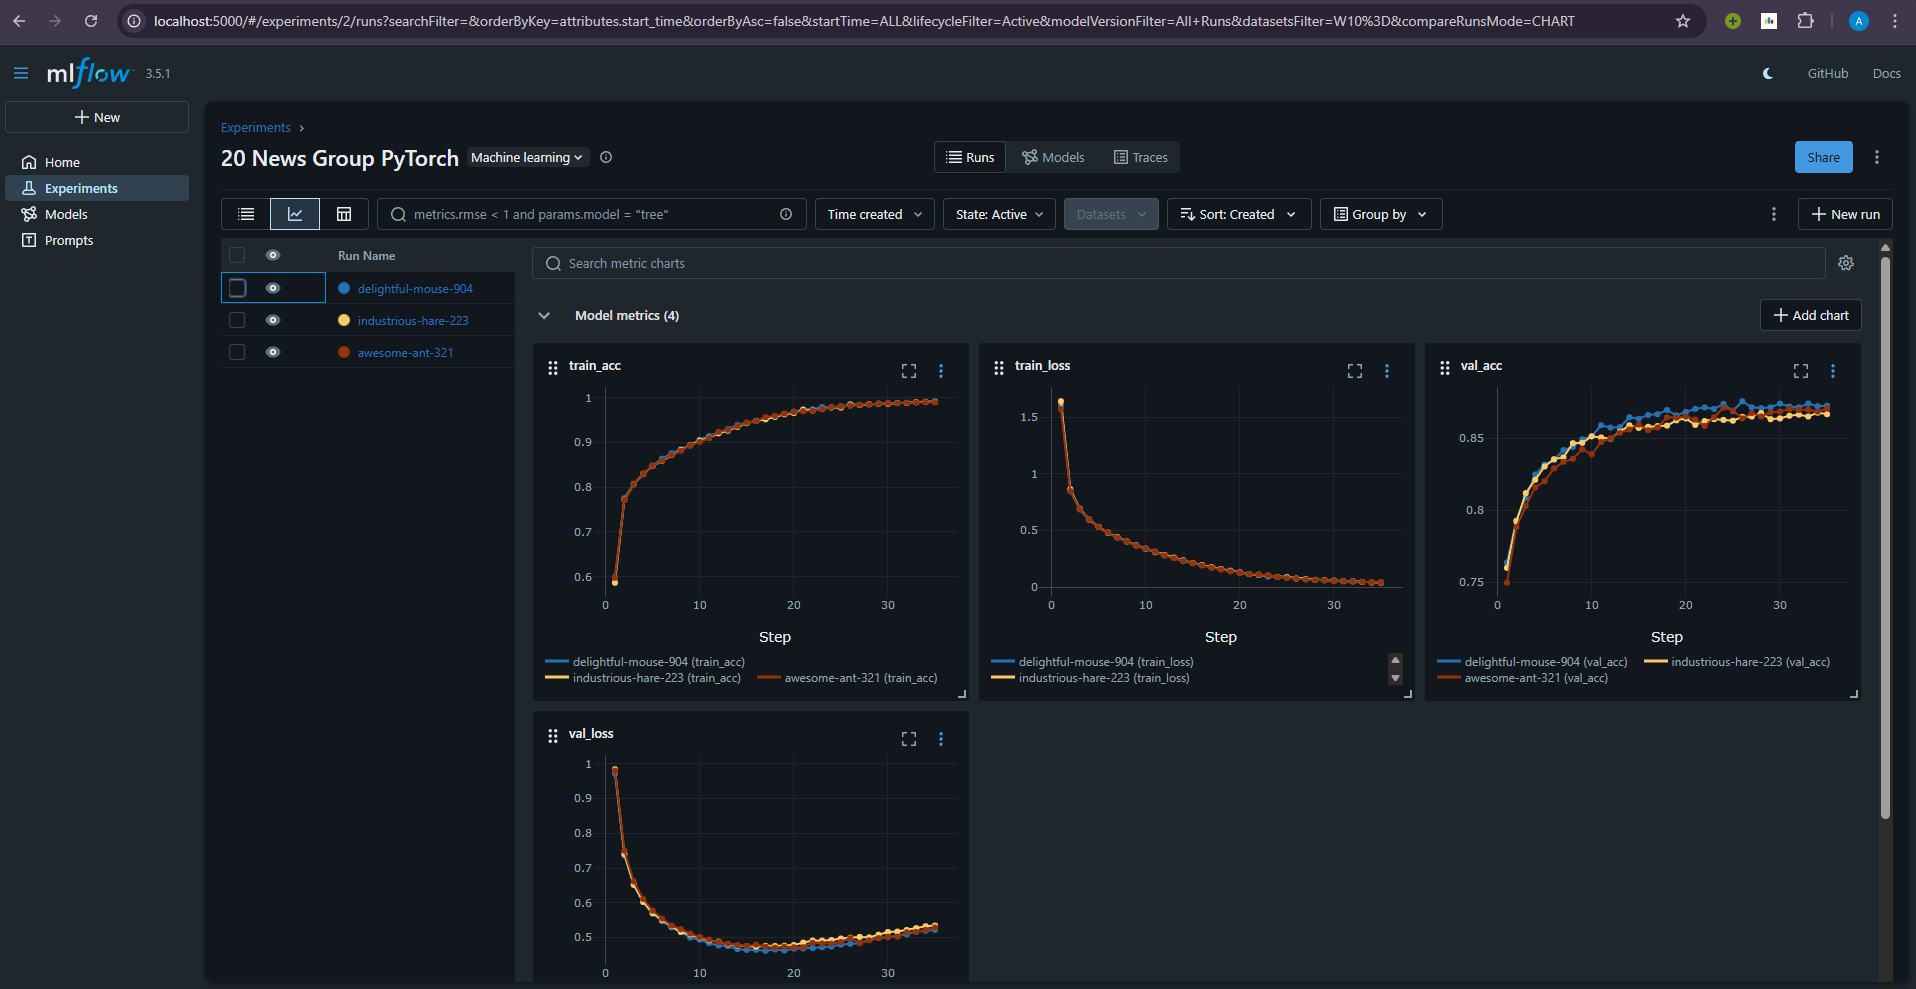

### MLflow best model overview

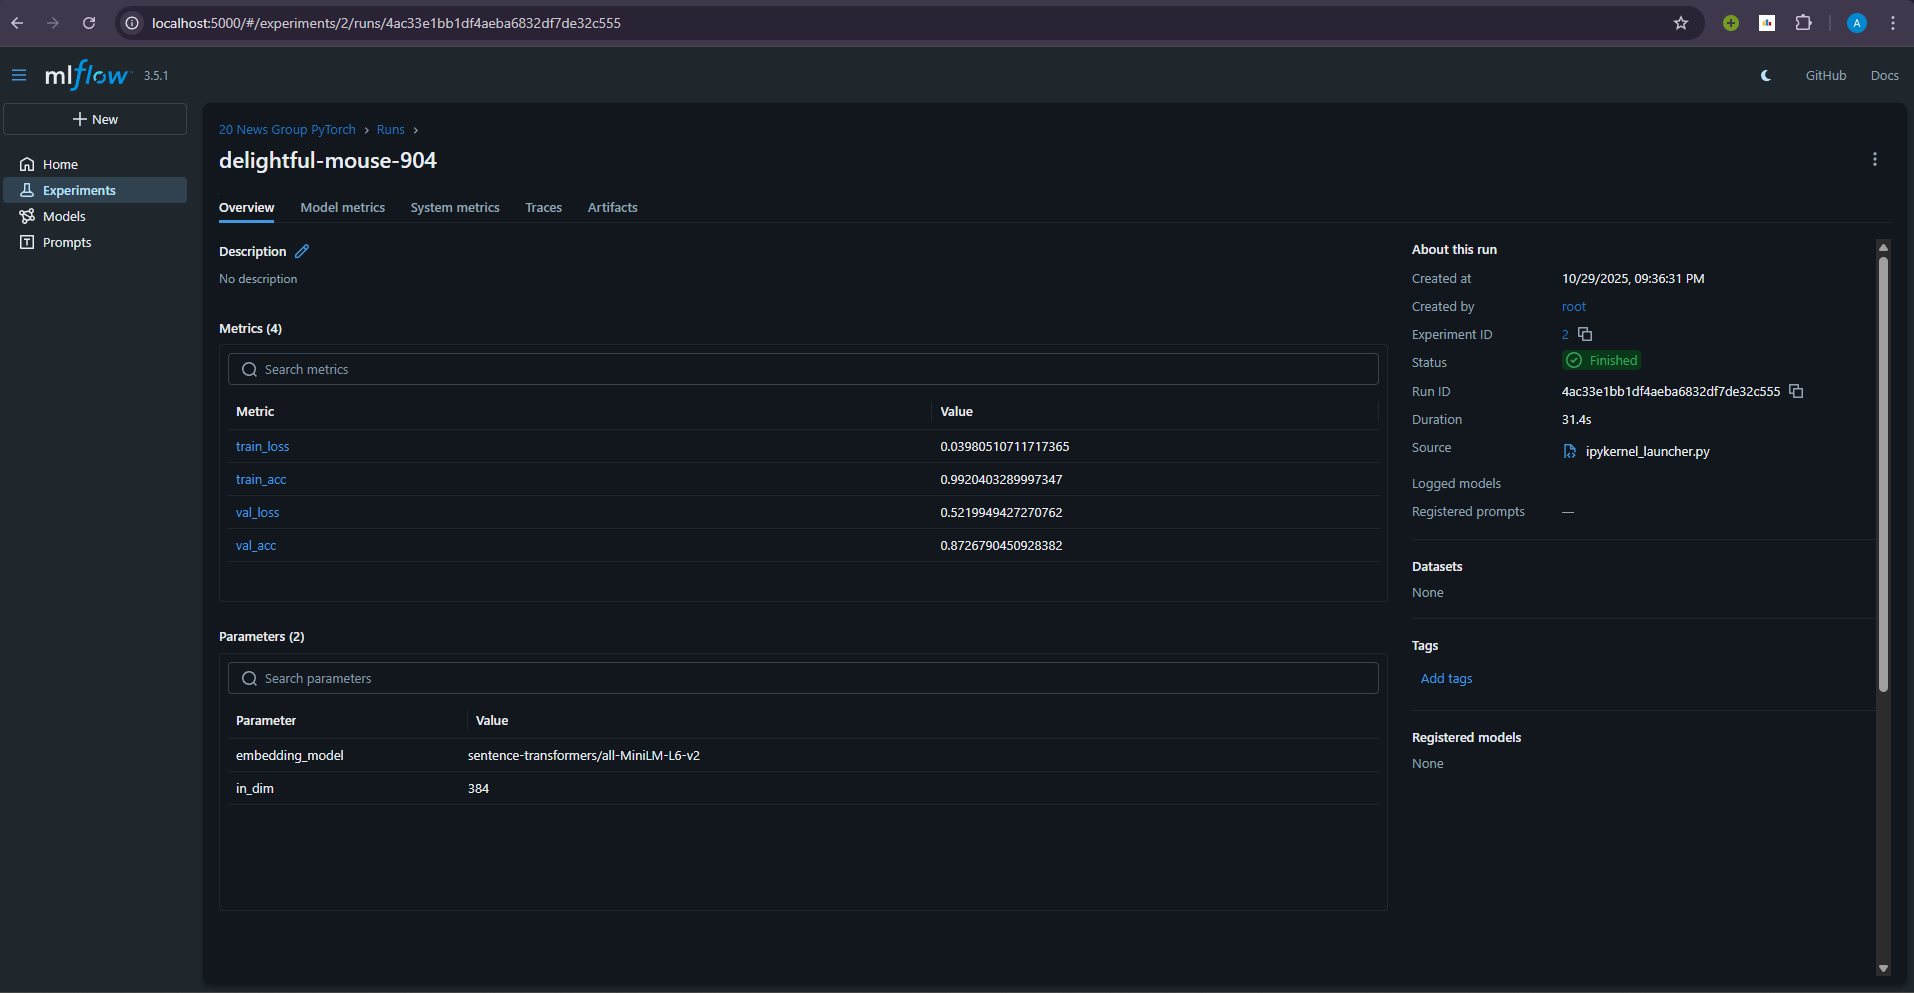
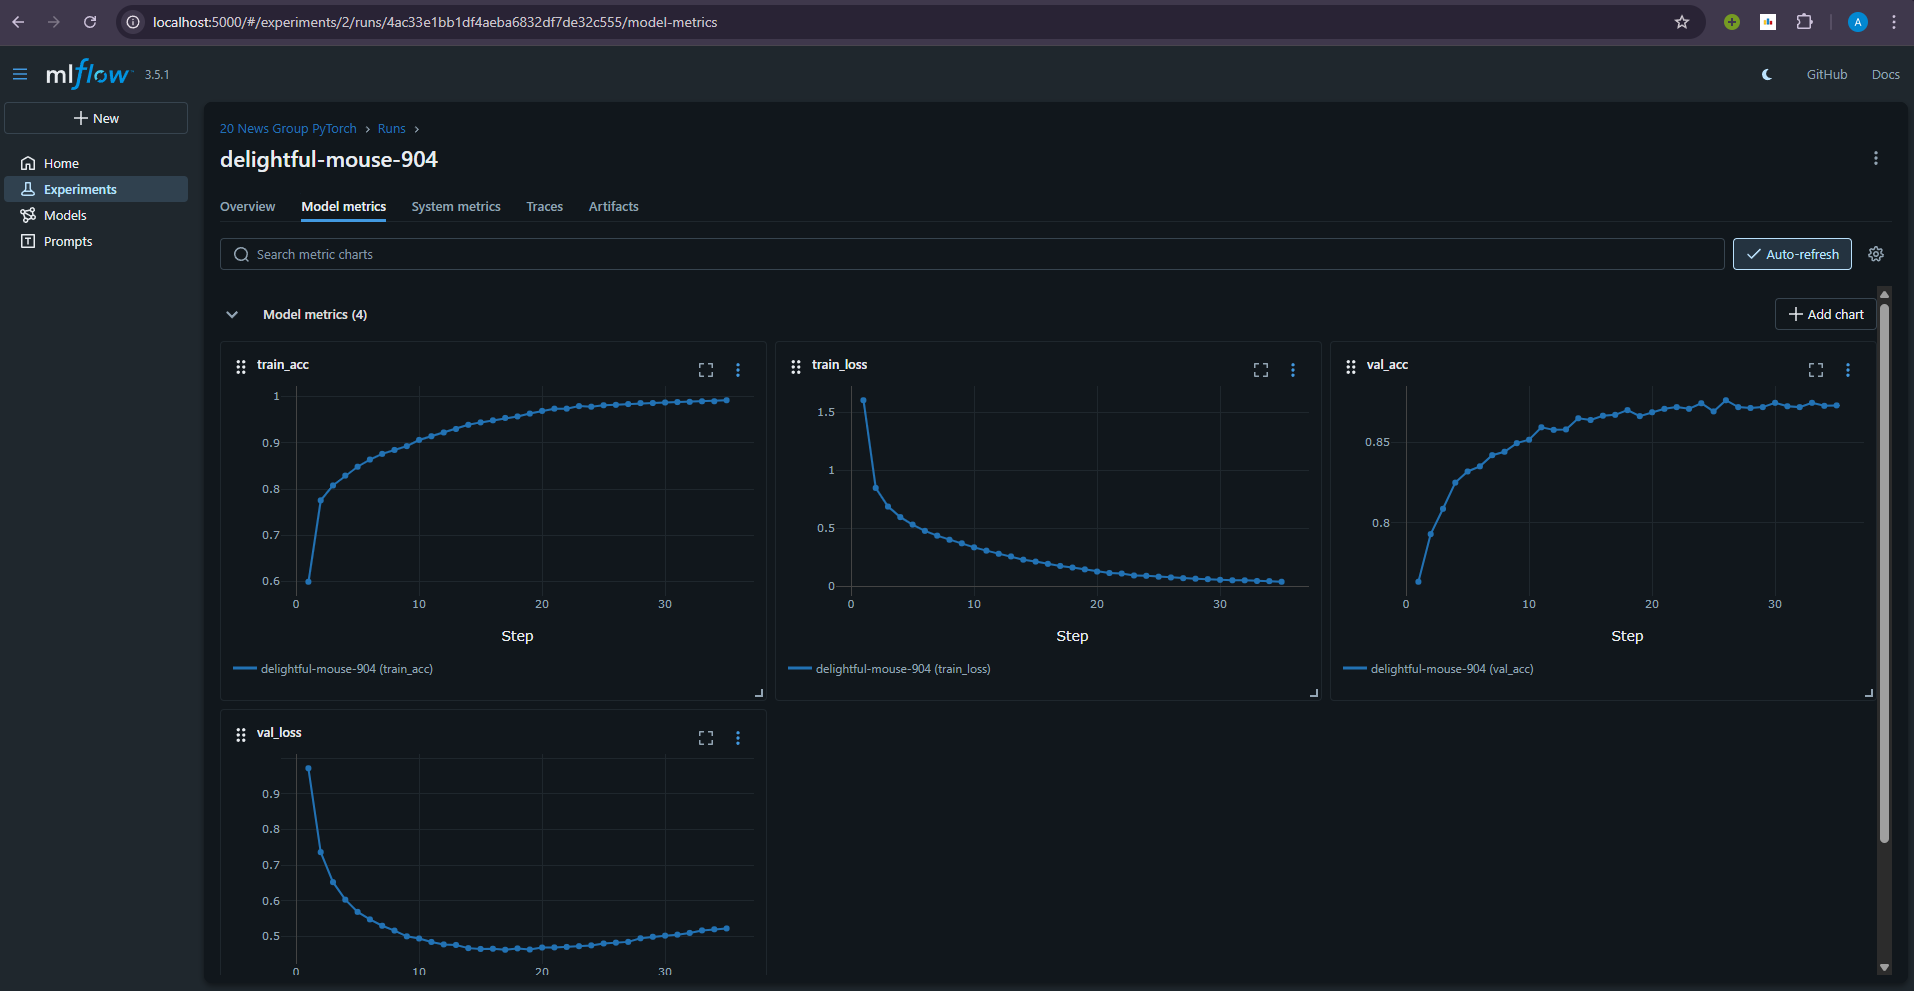

### MLflow best model metrics

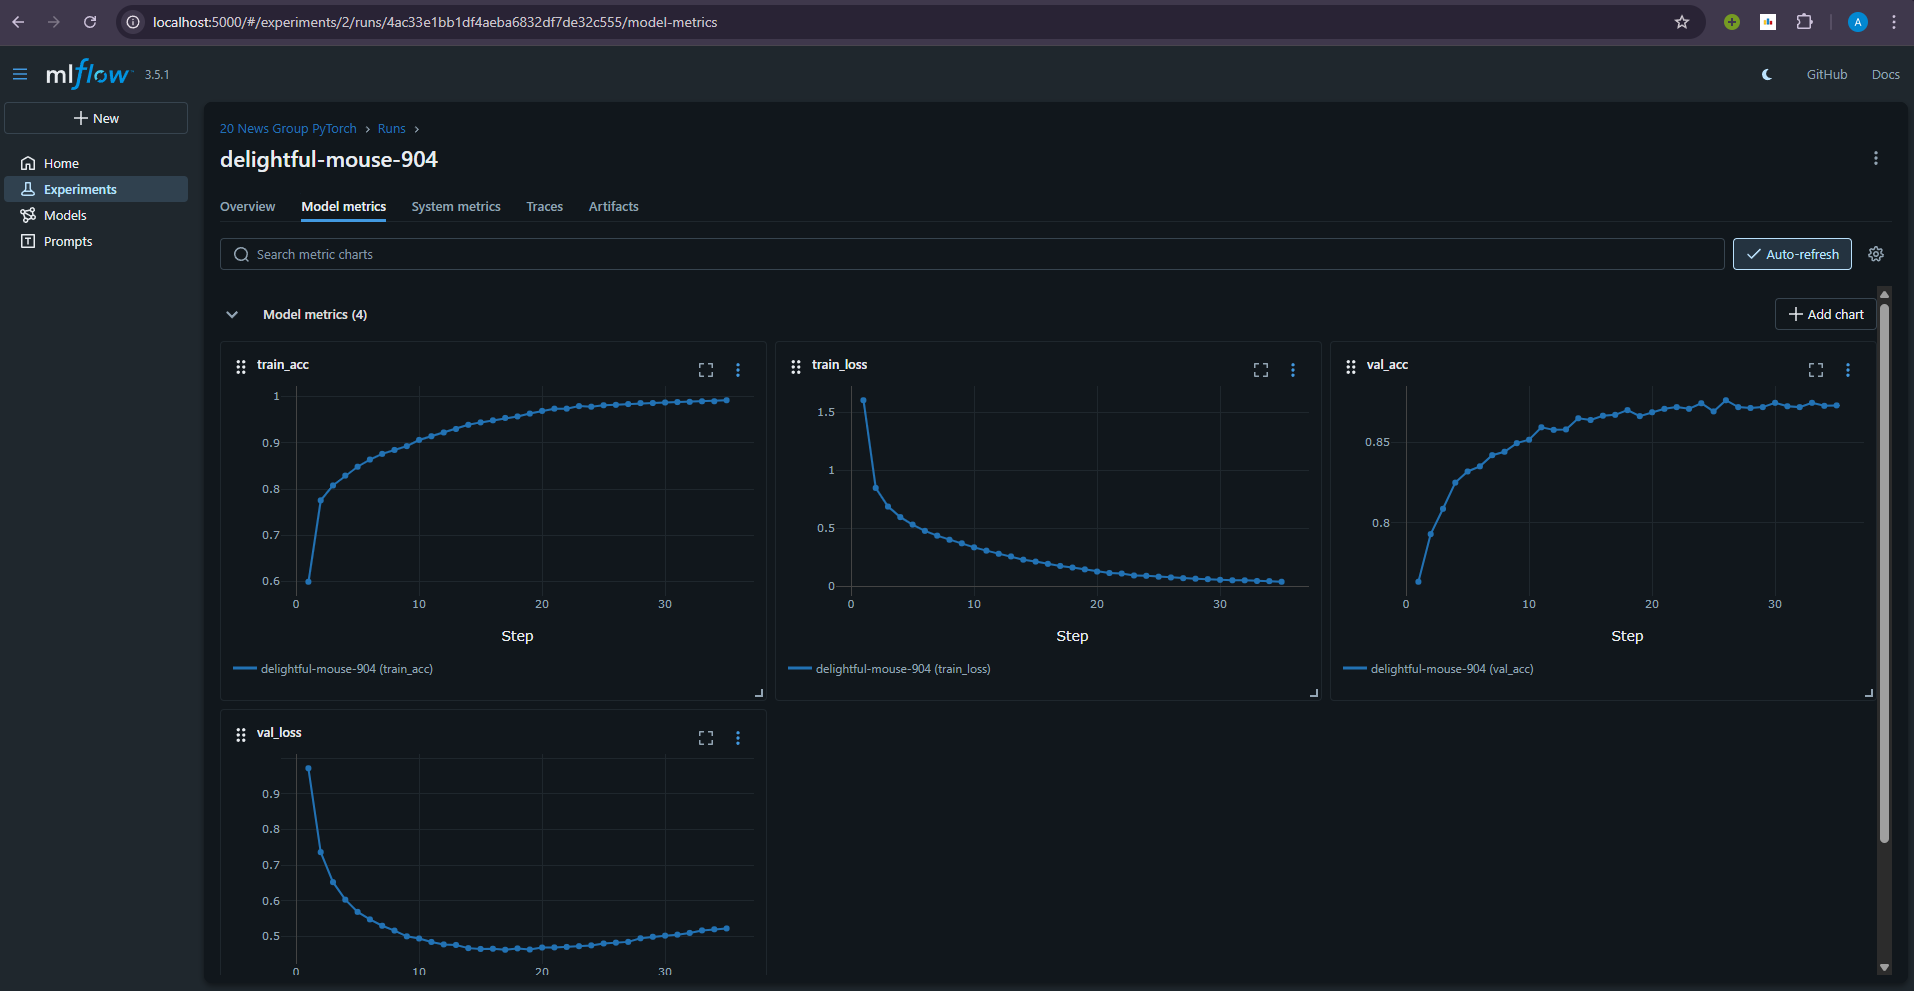
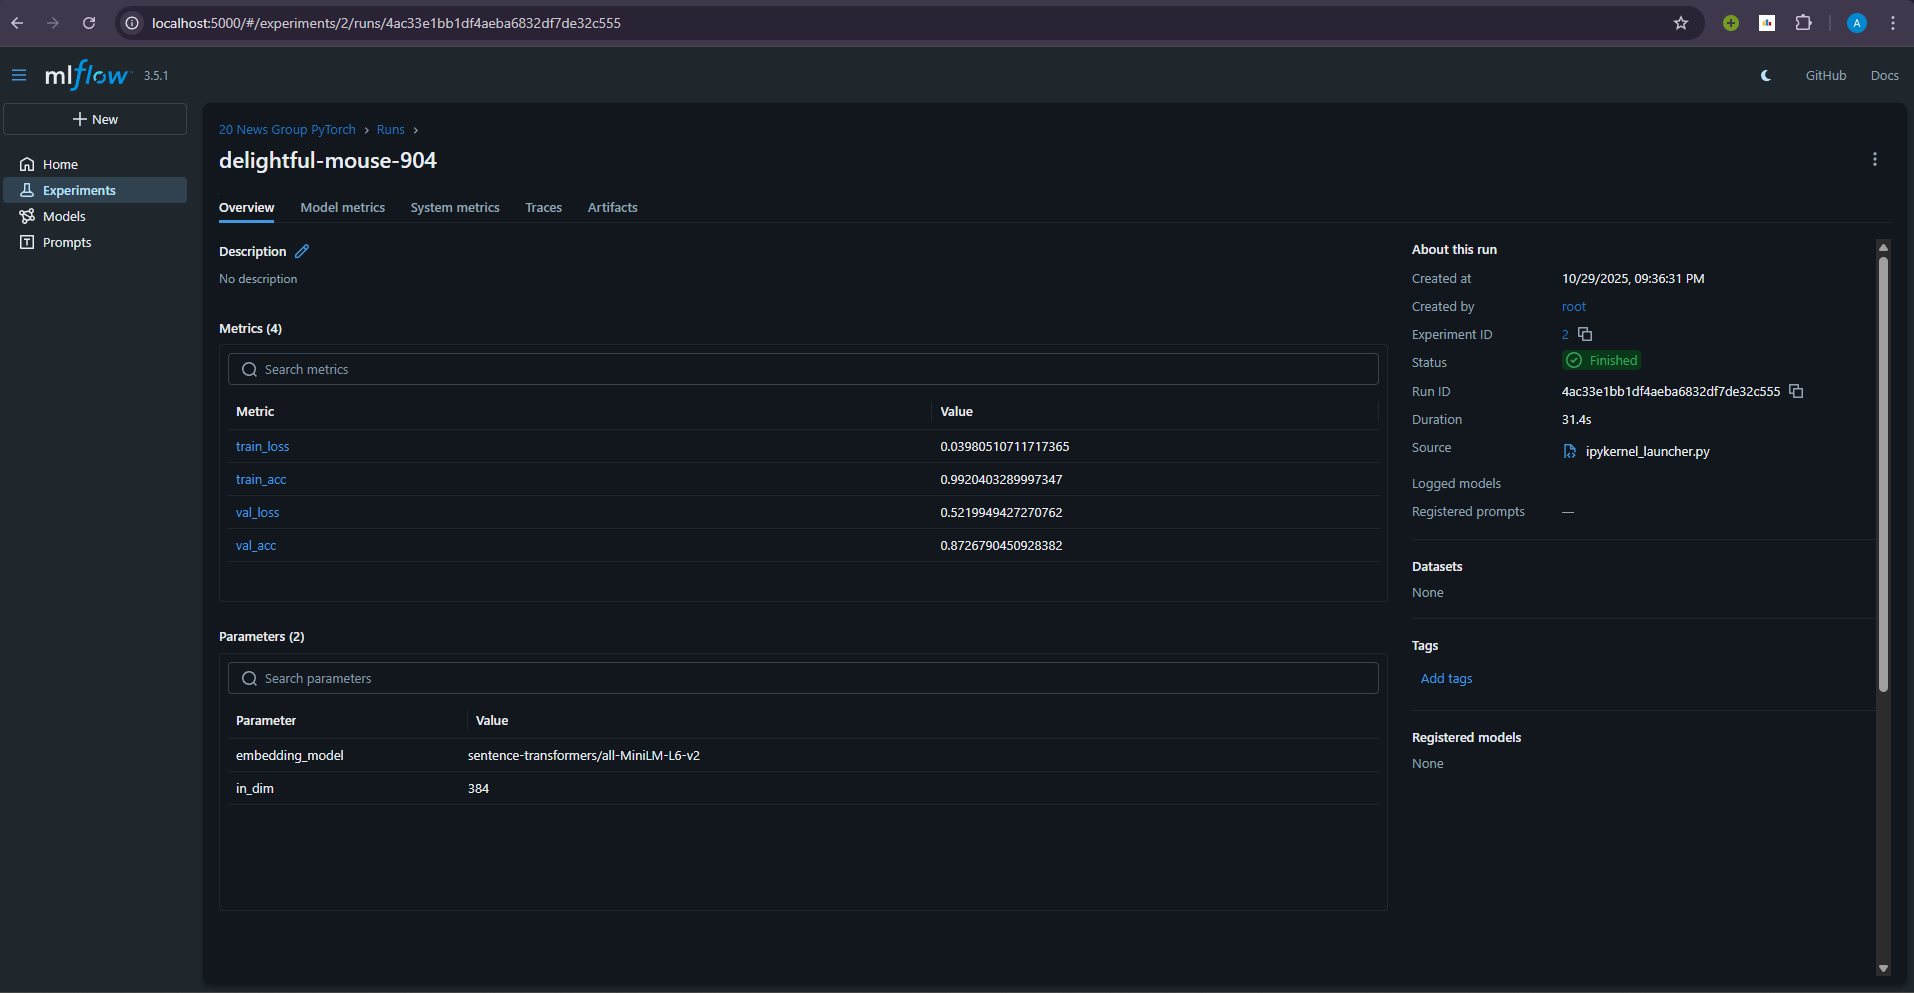

## Model Explainability

### Integrated Gradients

In [21]:
from captum.attr import IntegratedGradients

In [22]:
model.eval()
ig = IntegratedGradients(model)

In [27]:
def explain_sample_ig(idx: int, target_mode: str = "true", n_steps: int = 64, k: int = 10):
    xb = X_val[idx:idx+1].to(device)
    yb = y_val[idx:idx+1].to(device)


    base = X_train.mean(dim=0, keepdim=True).to(device)

    with torch.no_grad():
        pred_class = model(xb).argmax(1)

    target = yb if target_mode == "true" else pred_class

    attr = ig.attribute(xb, target=target, baselines=base, n_steps=n_steps)[0].detach().cpu()

    # Top positive (push towards target) and negative (push away) dims
    pos_vals, pos_idx = torch.topk(attr, k=k)
    neg_vals, neg_idx = torch.topk(-attr, k=k)
    top_pos = [(int(i), float(v)) for i, v in zip(pos_idx, pos_vals)]
    top_neg = [(int(i), float(-neg_vals[j])) for j, i in enumerate(neg_idx)]

    # Completeness check: sum(attr) ≈ logit(x) - logit(baseline) for chosen target
    t = int(target.item())
    with torch.no_grad():
        logit_x = model(xb)[0, t].item()
        logit_b = model(base)[0, t].item()
    completeness = float(attr.sum().item())
    logit_diff = logit_x - logit_b

    return {
        "top_positive": top_pos,
        "top_negative": top_neg,
        "sum_attributions": completeness,
        "logit_diff": logit_diff,
        "target_class": t,
    }

In [28]:
import pandas as pd
import altair as alt

def plot_ig_explanation(idx: int = 0, target_mode: str = "true", n_steps: int = 64, k: int = 10):
    res = explain_sample_ig(idx=idx, target_mode=target_mode, n_steps=n_steps, k=k)

    pos = [(i, v, "positive") for i, v in res["top_positive"]]
    neg = [(i, v, "negative") for i, v in res["top_negative"]]
    df = pd.DataFrame(pos + neg, columns=["dim", "attribution", "sign"])
    df["abs_attr"] = df["attribution"].abs()
    df["dim_label"] = df["dim"].apply(lambda d: f"dim {d}")

    cls_name = data.target_names[res["target_class"]]

    color_scale = alt.Scale(domain=["negative", "positive"], range=["#d62728", "#1f77b4"])

    bars = (
        alt.Chart(df)
        .mark_bar()
        .encode(
            y=alt.Y("dim_label:N",
                    sort=alt.SortField(field="abs_attr", order="descending"),
                    title="Embedding dimension"),
            x=alt.X("attribution:Q", title="IG attribution"),
            color=alt.Color("sign:N", scale=color_scale, title="Effect"),
            tooltip=[
                alt.Tooltip("dim:N", title="Dim"),
                alt.Tooltip("attribution:Q", title="Attribution", format=".4f"),
                alt.Tooltip("sign:N", title="Effect"),
            ],
        )
        .properties(width=800, height=420,
                    title=f"Integrated Gradients | sample idx={idx}, class={cls_name}")
    )

    zero_rule = alt.Chart(pd.DataFrame({"x": [0]})).mark_rule(color="#888", strokeDash=[4, 4]).encode(x="x:Q")

    summary = alt.Chart(
        pd.DataFrame({
            "label": [f"sum(attr) = {res['sum_attributions']:.3f} | logit_diff = {res['logit_diff']:.3f}"]
        })
    ).mark_text(align="left").encode(text="label:N").properties(width=800, height=20)

    return (bars + zero_rule) & summary

In [26]:
plot_ig_explanation(idx=0, k=10)

alt.VConcatChart(...)

# PyCaret

## Data Preprocessing PyCaret

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    df['text'], df['target'], df.index,
    test_size=0.2, random_state=42, stratify=df['target']
)

In [27]:
tfidf = TfidfVectorizer(max_features=8192, min_df=5, max_df=0.8,
                      stop_words='english', ngram_range=(1, 1))

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [28]:
svd = TruncatedSVD(n_components=512, random_state=42)

X_train_reduced = svd.fit_transform(X_train_tfidf)
X_val_reduced = svd.transform(X_val_tfidf)

In [29]:
feat_cols = [f"tfidf_{i}" for i in range(X_train_reduced.shape[1])]

df_train_features = pd.DataFrame(X_train_reduced, index=idx_train, columns=feat_cols)
df_val_features   = pd.DataFrame(X_val_reduced,   index=idx_val,   columns=feat_cols)

In [30]:
df_reduced_features = pd.concat([df_train_features, df_val_features], axis=0).reindex(df.index)

In [36]:
df_pycaret = pd.concat([df['target_name'], df_reduced_features], axis=1)

In [37]:
df_pycaret

,target_name,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,...,tfidf_502,tfidf_503,tfidf_504,tfidf_505,tfidf_506,tfidf_507,tfidf_508,tfidf_509,tfidf_510,tfidf_511
0,rec.sport.hockey,0.117742,0.001348,0.092803,-0.053607,0.108257,-0.059934,-0.022348,-0.027394,-0.073401,...,0.019768,-0.027867,-0.018821,-0.011350,0.012619,-0.007919,0.011431,-0.016265,-0.023168,0.012836
1,comp.sys.ibm.pc.hardware,0.127515,-0.104206,0.023452,0.067564,-0.001279,0.014404,0.072083,-0.026507,-0.020132,...,-0.005437,-0.013425,0.008913,-0.042633,0.016618,-0.019088,0.012104,-0.042119,-0.019701,0.002076
2,talk.politics.mideast,0.146065,0.091894,-0.014790,-0.021059,-0.075706,-0.143985,0.118414,0.147858,0.065927,...,0.005514,0.010457,0.012150,0.003870,0.044922,0.000733,-0.031152,0.016593,0.003964,-0.009983
3,comp.sys.ibm.pc.hardware,0.138963,-0.144268,-0.127663,0.088336,0.049152,-0.006205,0.198553,-0.103500,-0.021326,...,-0.007022,-0.011462,-0.036904,0.031117,0.021514,0.006937,0.013851,-0.047499,-0.020711,-0.002055
4,comp.sys.mac.hardware,0.178127,-0.112679,0.048778,0.057655,0.004161,-0.007204,0.051622,-0.095469,-0.044161,...,-0.027170,0.015934,-0.025192,-0.003789,0.000018,0.023316,0.003130,0.001108,-0.003729,0.006684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,sci.med,0.093370,0.025443,-0.025645,-0.024250,0.007743,0.004839,0.001478,0.008550,-0.005973,...,0.023616,0.000600,-0.006676,-0.020450,-0.014635,-0.037147,-0.002629,-0.006388,-0.035070,-0.029329
18842,sci.electronics,0.104765,-0.016952,-0.007481,-0.038853,0.015649,0.034434,0.003949,0.000669,0.008079,...,-0.002564,0.034114,0.019392,0.016398,-0.025195,-0.006755,-0.030680,0.013273,0.026550,0.034655
18843,comp.sys.ibm.pc.hardware,0.079723,-0.040441,-0.073439,-0.006139,0.011215,0.019707,0.027599,-0.019003,-0.029841,...,-0.002573,-0.014681,-0.031624,-0.026475,-0.010991,0.045355,-0.003349,0.024077,0.003990,0.018703
18844,comp.graphics,0.126717,-0.019496,0.017628,-0.004425,-0.014833,-0.019243,-0.050065,-0.018450,0.034587,...,-0.066821,-0.002686,0.028018,-0.022300,0.000562,-0.024376,0.003313,0.033630,-0.001633,-0.022251


## Experiment Run

In [38]:
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

Did not add logging to MLflow because PyCaret 2.0 API is not compatible with MLflow 3.0  API.

Added to the neural network via PyTorch instead

In [39]:
# log_experiment = True, experiment_name = 'diamond'
exp.setup(df_pycaret, target = 'target_name', train_size=0.8, session_id = 1)

,Description,Value
0,Session id,1
1,Target,target_name
2,Target type,Multiclass
3,Target mapping,"alt.atheism: 0, comp.graphics: 1, comp.os.ms-windows.misc: 2, comp.sys.ibm.pc.hardware: 3, comp.sys.mac.hardware: 4, comp.windows.x: 5, misc.forsale: 6, rec.autos: 7, rec.motorcycles: 8, rec.sport.baseball: 9, rec.sport.hockey: 10, sci.crypt: 11, sci.electronics: 12, sci.med: 13, sci.space: 14, soc.religion.christian: 15, talk.politics.guns: 16, talk.politics.mideast: 17, talk.politics.misc: 18, talk.religion.misc: 19"
4,Original data shape,"(18846, 513)"
5,Transformed data shape,"(18846, 513)"
6,Transformed train set shape,"(15076, 513)"
7,Transformed test set shape,"(3770, 513)"
8,Numeric features,512
9,Preprocess,True


In [40]:
exp.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [41]:
exclude=['gbc', 'rbfsvm', 'gpc', 'qda', 'ada', 'lda']
include=['lr', 'knn', 'nb', 'dt', 'svm', 'mlp', 'ridge', 'rf', 'et', 'lightgbm', 'dummy']

## Best Model Selection

In [42]:
best = exp.compare_models(include=include, cross_validation=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8581,0.9902,0.8581,0.8596,0.8573,0.8505,0.8506,7.5700
mlp,MLP Classifier,0.8552,0.9901,0.8552,0.8562,0.8552,0.8475,0.8475,82.1100
ridge,Ridge Classifier,0.8517,0.0000,0.8517,0.8518,0.8490,0.8438,0.8440,0.5000
svm,SVM - Linear Kernel,0.8451,0.0000,0.8451,0.8501,0.8408,0.8368,0.8374,0.6700
lightgbm,Light Gradient Boosting Machine,0.8353,0.9884,0.8353,0.8396,0.8362,0.8265,0.8266,83.5100
et,Extra Trees Classifier,0.8011,0.9723,0.8011,0.8059,0.7995,0.7904,0.7907,3.4200
rf,Random Forest Classifier,0.8000,0.9745,0.8000,0.8037,0.7972,0.7893,0.7896,4.1700
knn,K Neighbors Classifier,0.7013,0.9214,0.7013,0.7427,0.7125,0.6854,0.6879,0.2500
nb,Naive Bayes,0.6464,0.9333,0.6464,0.6771,0.6542,0.6276,0.6287,0.6200
dt,Decision Tree Classifier,0.5358,0.7556,0.5358,0.5360,0.5353,0.5111,0.5112,14.1000


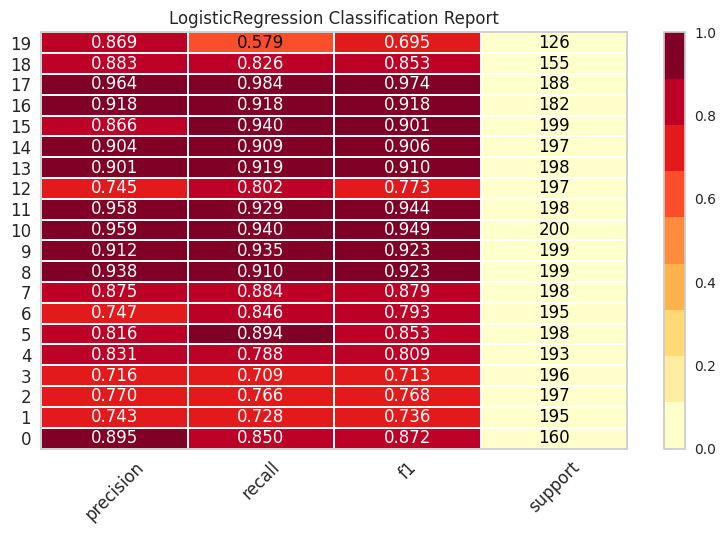

In [43]:
exp.plot_model(best, plot = 'class_report')

## Model Explainability

### Feature Importance

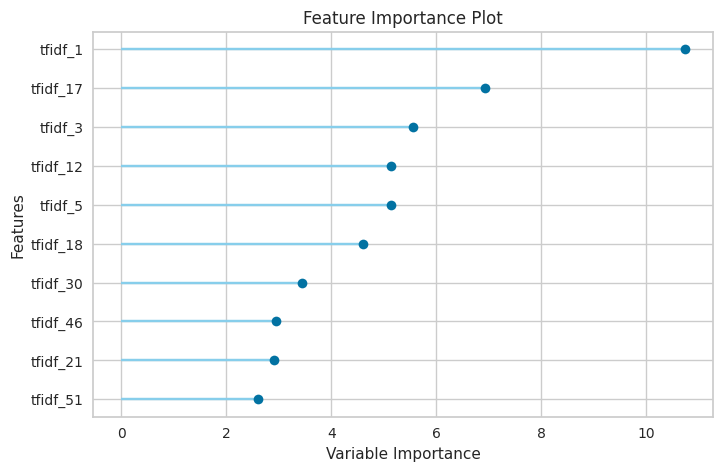

In [44]:
exp.plot_model(best, plot = 'feature')

### Word-level Importance

In [45]:
import pandas as pd
import altair as alt

word_weights = svd.components_.T @ best.coef_.T

feat_names = np.array(tfidf.get_feature_names_out())

def word_importance_df(c: int, k: int = 20) -> pd.DataFrame:
    # Requires: word_weights (n_features, n_classes), feat_names (n_features,)
    w = word_weights[:, c]
    idx_pos = np.argsort(w)[-k:][::-1]
    idx_neg = np.argsort(w)[:k]

    df_pos = pd.DataFrame({
        "word": feat_names[idx_pos],
        "weight": w[idx_pos],
        "sign": "positive",
    })
    df_neg = pd.DataFrame({
        "word": feat_names[idx_neg],
        "weight": w[idx_neg],
        "sign": "negative",
    })
    df_all = pd.concat([df_pos, df_neg], ignore_index=True)
    df_all["abs_weight"] = df_all["weight"].abs()
    df_all["class_id"] = c
    df_all["class_name"] = data.target_names[c]
    return df_all

def plot_word_importance(c: int, k: int = 20):
    df_imp = word_importance_df(c, k)

    color_scale = alt.Scale(domain=["negative", "positive"], range=["#d62728", "#1f77b4"])

    bars = (
        alt.Chart(df_imp)
        .mark_bar()
        .encode(
            y=alt.Y("word:N",
                    sort=alt.SortField(field="abs_weight", order="descending"),
                    title="Word"),
            x=alt.X("weight:Q", title="Projected weight (word-space)"),
            color=alt.Color("sign:N", scale=color_scale, title="Effect"),
            tooltip=[
                alt.Tooltip("word:N", title="Word"),
                alt.Tooltip("weight:Q", title="Weight", format=".4f"),
                alt.Tooltip("sign:N", title="Effect"),
                alt.Tooltip("class_name:N", title="Class"),
            ],
        )
        .properties(width=1000, height=600,
                    title=f"Word importance for class: {data.target_names[c]}")
    )

    zero_rule = alt.Chart(pd.DataFrame({"x":[0]})).mark_rule(color="#888", strokeDash=[4,4]).encode(x="x:Q")

    return (bars + zero_rule).configure_axis(labelFontSize=12, titleFontSize=12).configure_legend(labelFontSize=12, titleFontSize=12)

In [54]:
cls = 19
cls_name = data.target_names[cls]
cls_name

'talk.religion.misc'

In [55]:
plot_word_importance(cls, k=20)

alt.LayerChart(...)